[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

It includes the following datasets

* train.csv
* test.csv
* sample_submission.csv
* stores.csv
* oil.csv
* holiday_events.csv

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

**Features**

Kaggle explains the features of all the provided datasets in the [competition data tab](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)



## Download Kaggle Data

Uncomment the below codeblock to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [2]:
# from google.colab import userdata
# import os
# 
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# 
# !kaggle competitions download -c store-sales-time-series-forecasting
# 
# ! unzip "store-sales-time-series-forecasting.zip" -d data

# EDA

In [3]:
# ensure required libraries are installed
!pip -q install sktime pmdarima seaborn

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')

Load the datasets

In [4]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
    
    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [5]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    category      
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(2), datetime64[ns](1), float32(1), int64(1), uint64(1)
memory usage: 85.9 MB


In [6]:
store_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     category
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(5)
memory usage: 5.1 KB


In [7]:
daily_oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 14.4 KB


In [8]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    string        
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(3), datetime64[ns](1), string(1)
memory usage: 8.0 KB


In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  category      
 2   transactions  83488 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.4 MB


## Data Visualization

Daily average sales of all product famliies across all stores

In [10]:
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)

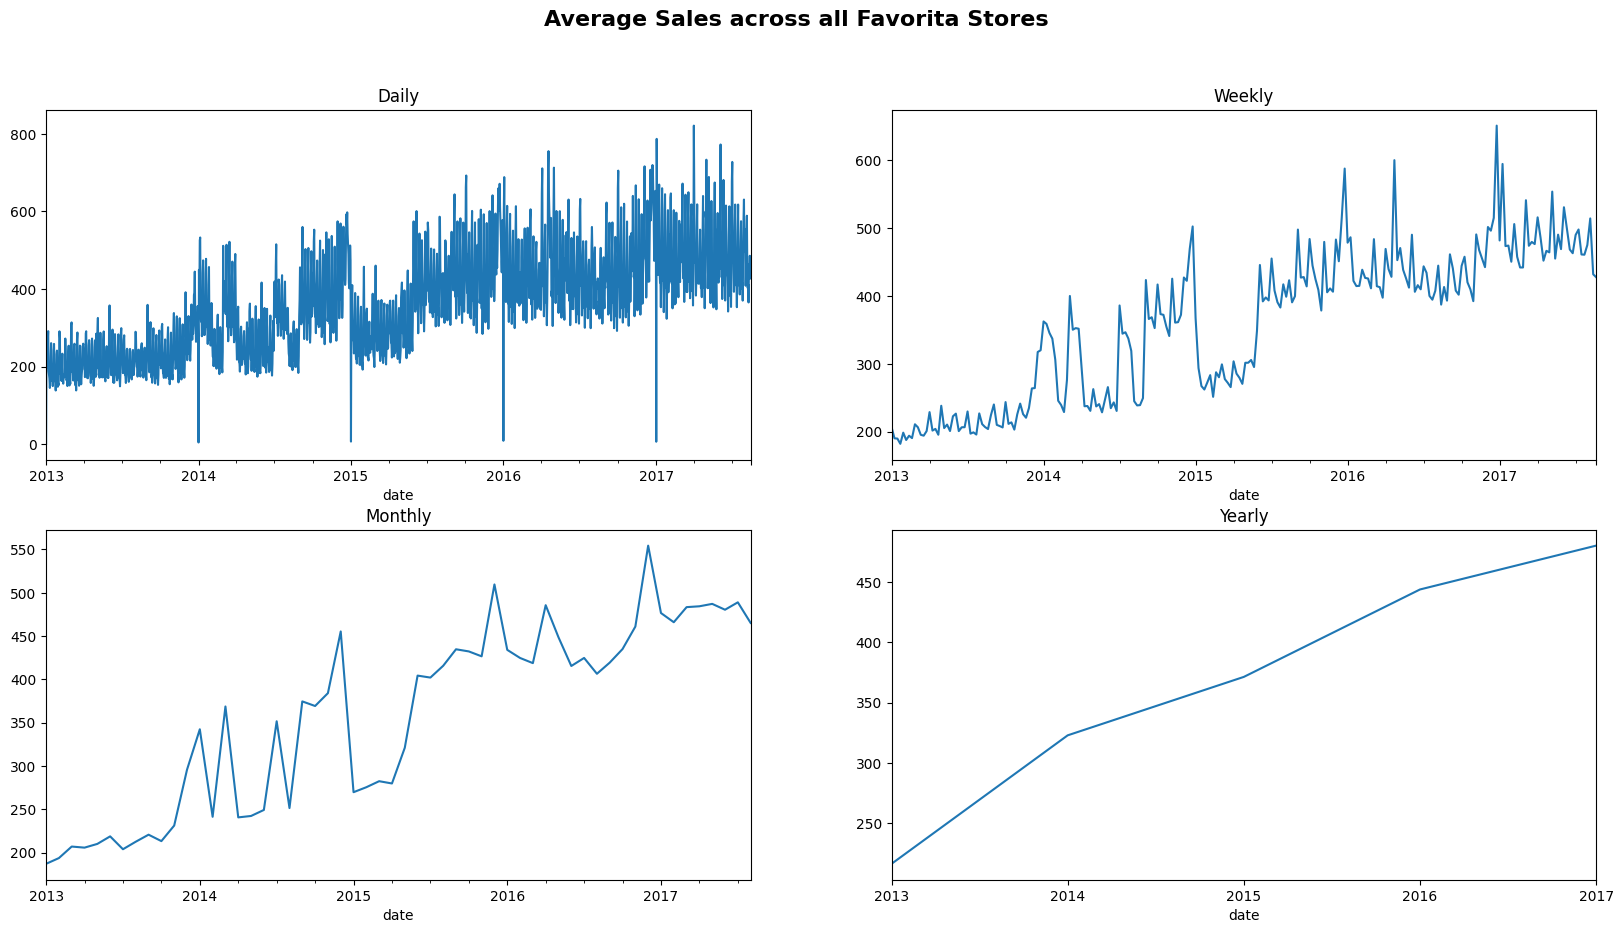

In [11]:
# Daily average sales of all product famliies across all stores
daily_average_sales = store_sales.groupby('date').mean()['sales']
weekly_average_sales = daily_average_sales.resample('W').mean()
monthly_average_sales = daily_average_sales.resample('M').mean()
yearly_average_sales = daily_average_sales.resample('Y').mean()

# Subplot option 2
fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(20,10),)
                       

fig.suptitle("Average Sales across all Favorita Stores", fontsize=16, fontweight="bold");

daily_average_sales.plot(x="date",
                           y="sales",
                           ax=ax[0,0],
                           title="Daily")

weekly_average_sales.plot(x="date",
                           y="sales",
                           ax=ax[0,1],
                           title="Weekly")

monthly_average_sales.plot(x="date",
                           y="sales",
                           ax=ax[1,0],
                           title="Monthly")

yearly_average_sales.plot(x="date",
                           y="sales",
                           ax=ax[1,1],
                           title="Yearly");

# _ = plot_series(, title="Daily average sales of all product famliies across all stores")

Daily average of PRODUCT sales accross all stores

In [12]:
# Group by 'date' and 'family', calculate mean sales
daily_avg_family_sales = store_sales.groupby(['date', 'family'])['sales'].mean().reset_index()

daily_avg_family_sales

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,0.037037
3,2013-01-01,BEVERAGES,15.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
55567,2017-08-15,POULTRY,325.679840
55568,2017-08-15,PREPARED FOODS,85.954132
55569,2017-08-15,PRODUCE,2316.832764
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,46.851852


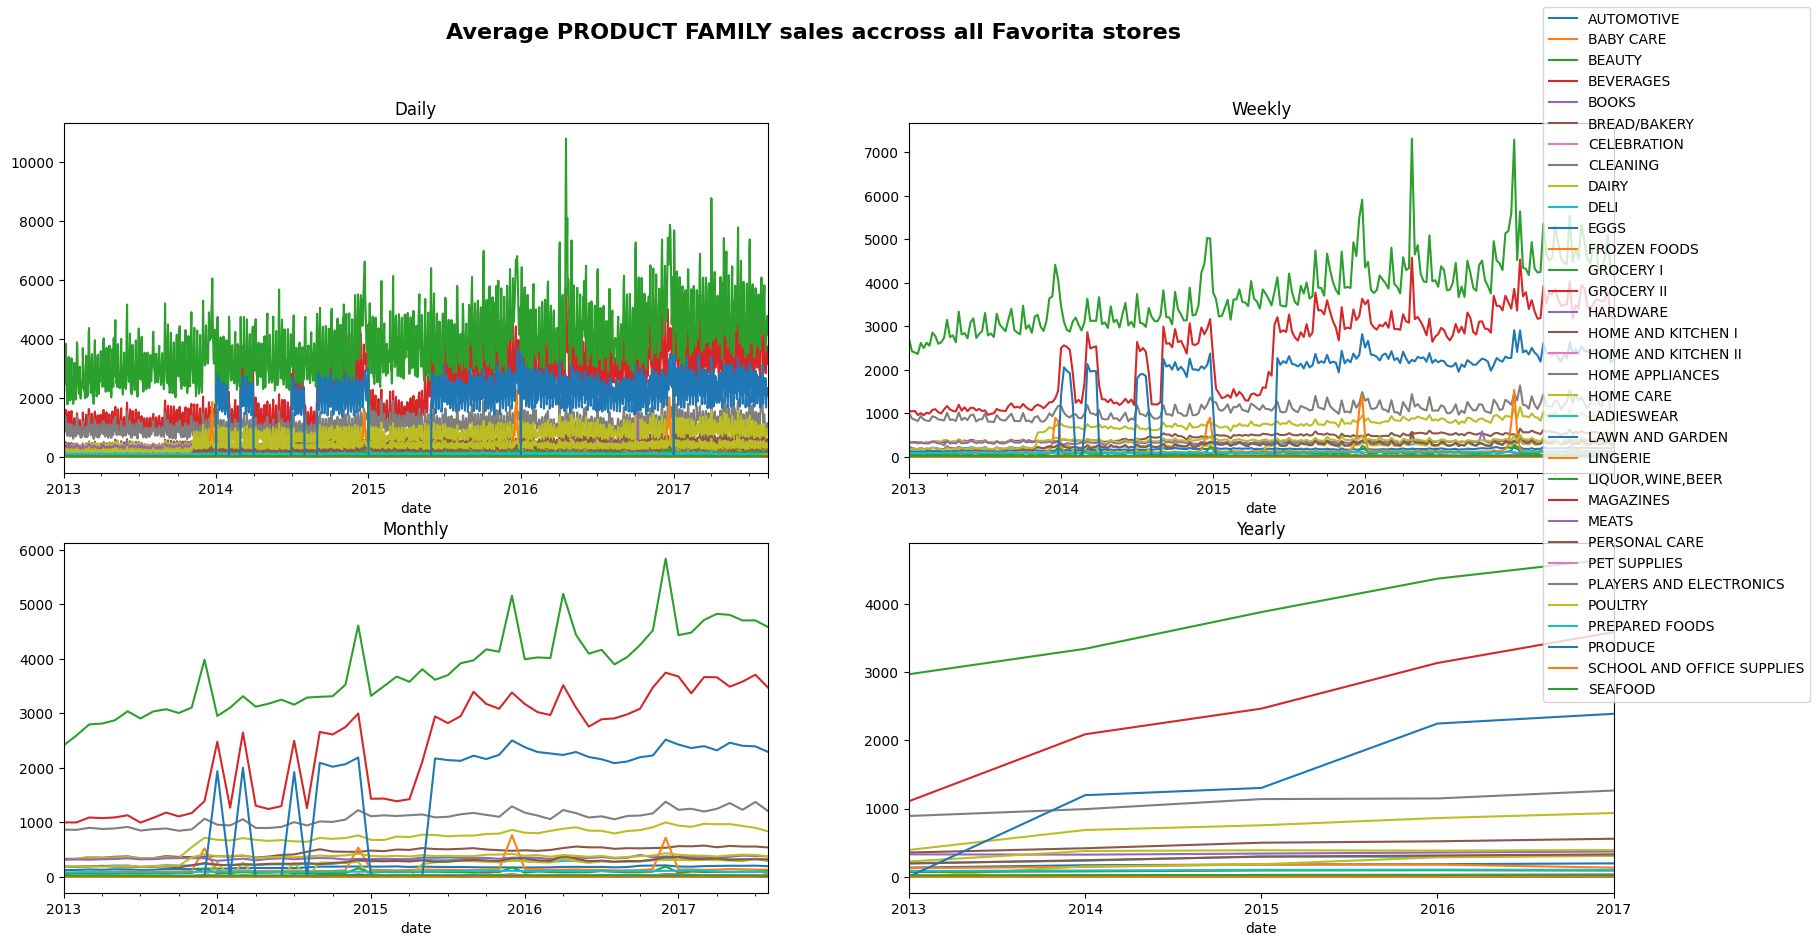

In [13]:
# Pivot the data for easier plotting (date as index, family as columns)
pivot_df = daily_avg_family_sales.pivot(index='date', columns='family', values='sales')

daily_average_sales = pivot_df
weekly_average_sales = daily_average_sales.resample('W').mean()
monthly_average_sales = daily_average_sales.resample('M').mean()
yearly_average_sales = daily_average_sales.resample('Y').mean()


fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(20,10))


fig.suptitle("Average PRODUCT FAMILY sales accross all Favorita stores", fontsize=16, fontweight="bold");

daily_average_sales.plot(ax=ax[0,0],
                           title="Daily")

weekly_average_sales.plot(ax=ax[0,1],
                           title="Weekly")

monthly_average_sales.plot(ax=ax[1,0],
                           title="Monthly")

yearly_average_sales.plot(ax=ax[1,1],
                           title="Yearly")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

# TREND

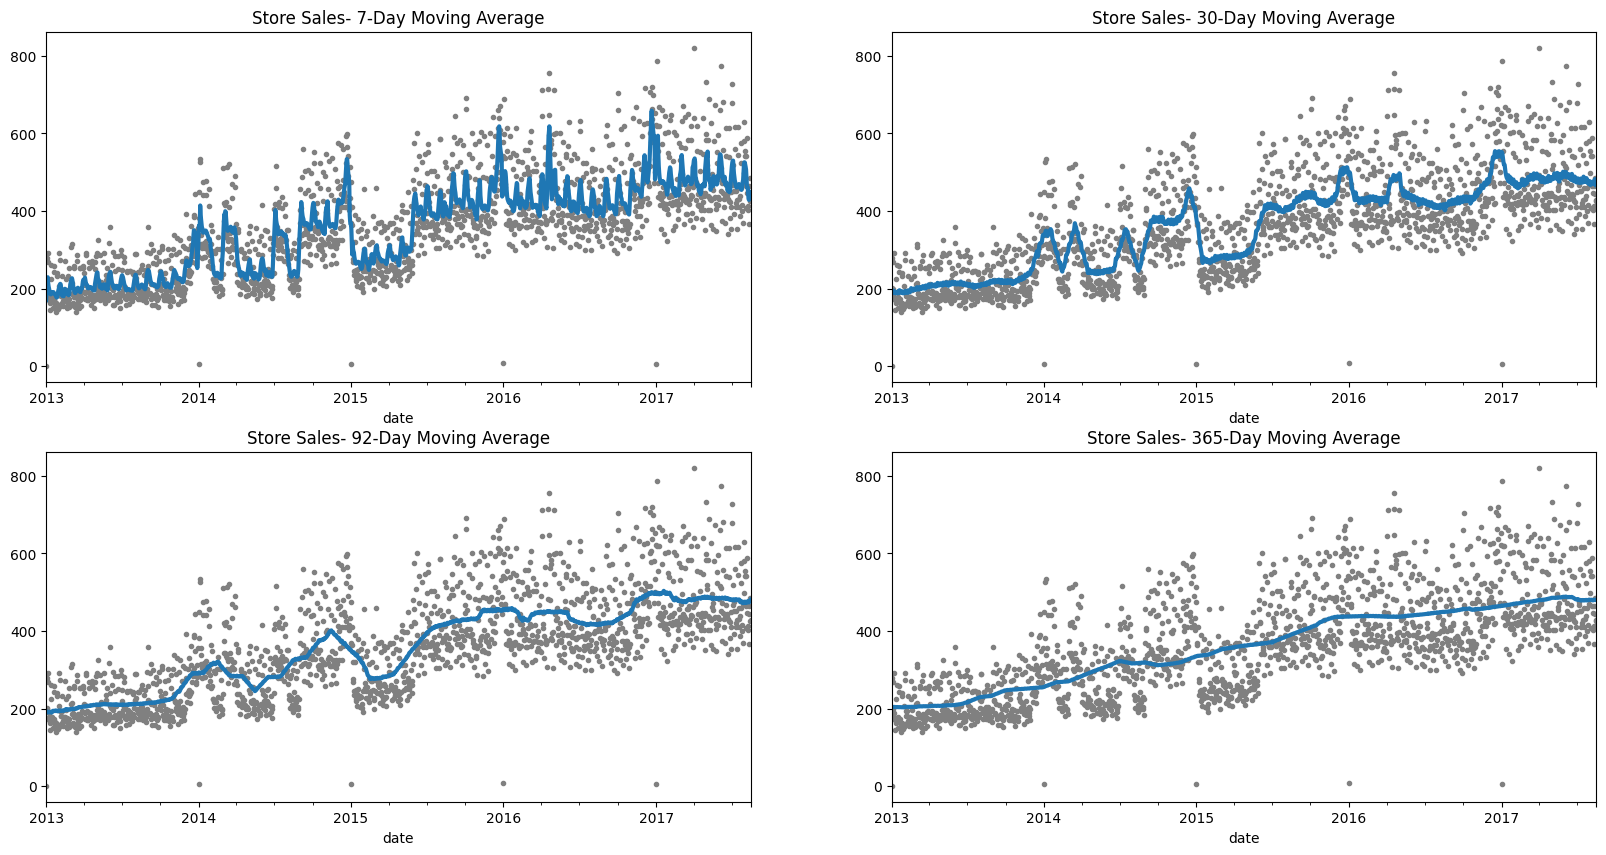

In [20]:
daily_average_sales = store_sales.groupby('date').mean()['sales']

def plot_moving_average(window, ax):
    moving_average = daily_average_sales.rolling(
        window=window,
        center=True, 
        min_periods=window//2
    ).mean()

    daily_average_sales.plot(style=".", color="0.5", ax=ax)
    moving_average.plot(
        ax=ax, linewidth=3, title=f"Store Sales- {window}-Day Moving Average", legend=False
    )

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(20,10))

windows = [7, 30, 92, 365]
axes =[ax1, ax2, ax3, ax4]

for window, ax in zip(windows, axes):
    plot_moving_average(window=window, ax=ax)